## [MYCODE] 데이터 다운로드 및 확인하기

In [1]:
import pandas as pd

train_data_path = (
    "/Users/yunhyeokchoi/Study/AI 99+/archive/train.csv"  # 실제 파일명으로 교체
)
test_data_path = "/Users/yunhyeokchoi/Study/AI 99+/archive/validation_matched.csv"
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
# 데이터 확인
print("--------------------------TRAIN DATA--------------------------")
print(train_data)
print("--------------------------TEST DATA--------------------------")
print(test_data.head())

--------------------------TRAIN DATA--------------------------
        promptID   pairID                                            premise  \
0          31193   31193n  Conceptually cream skimming has two basic dime...   
1         101457  101457e  you know during the season and i guess at at y...   
2         134793  134793e  One of our number will carry out your instruct...   
3          37397   37397e  How do you know? All this is their information...   
4          50563   50563n  yeah i tell you what though if you go price so...   
...          ...      ...                                                ...   
392697     30418   30418c    Clearly, California can - and must - do better.   
392698    105454  105454n  It was once regarded as the most beautiful str...   
392699     13960   13960e  Houseboats are a beautifully preserved traditi...   
392700    114061  114061n  Obituaries fondly recalled his on-air debates ...   
392701      2065    2065n  in that other you know uh that

## [LOG] 데이터 확인하기

In [2]:
from datasets import Dataset


print(train_data.shape)
print(train_data.columns)

print(train_data.iloc[0, 2])  # premise
print(train_data.iloc[0, 5])  # hypothesis
print(train_data.iloc[0, 9])  # label

print(train_data.iloc[1, 2])  # premise
print(train_data.iloc[1, 5])  # hypothesis
print(train_data.iloc[1, 9])  # label

print(train_data.iloc[2, 2])  # premise
print(train_data.iloc[2, 5])  # hypothesis
print(train_data.iloc[2, 9])  # label

print(test_data.shape)



(392702, 10)
Index(['promptID', 'pairID', 'premise', 'premise_binary_parse',
       'premise_parse', 'hypothesis', 'hypothesis_binary_parse',
       'hypothesis_parse', 'genre', 'label'],
      dtype='object')
Conceptually cream skimming has two basic dimensions - product and geography.
Product and geography are what make cream skimming work. 
1
you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the Braves decide to call to recall a guy from triple A then a double A guy goes up to replace him and a single A guy goes up to replace him
You lose the things to the following level if the people recall.
0
One of our number will carry out your instructions minutely.
A member of my team will execute your orders with immense precision.
0
(9815, 10)


## [MYCODE] 학습에 맞도록 데이터 수정 및 확인하기

In [3]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset

train_data = Dataset.from_pandas(train_data)
test_data = Dataset.from_pandas(test_data)

tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")

unnecessary_col = [
    "promptID",
    "pairID",
    "premise_binary_parse",
    "premise_parse",
    "hypothesis_binary_parse",
    "hypothesis_parse",
    "genre",
]

# 필요한 열만 유지
train_data = train_data.remove_columns(unnecessary_col)
test_data = test_data.remove_columns(unnecessary_col)

print(train_data[0])  # 정리된 데이터 확인


def collate_fn(batch):
    text_1, text_2, labels = [], [], []
    for row in batch:
        if row["premise"] and row["hypothesis"]:  # None 또는 빈 값 확인
            text_1.append(row["premise"])
            text_2.append(row["hypothesis"])
            labels.append(row["label"])

    if len(text_1) == 0 or len(text_2) == 0:
        raise ValueError("Batch contains no valid data.")

    encodings = tokenizer(
        text_1, text_pair=text_2, padding=True, truncation=True, return_tensors="pt"
    )
    return encodings["input_ids"], torch.tensor(labels)


train_data = train_data.select(range(20000))  # 학습 시간을 고려해 데이터 줄이기
train_data = train_data.with_format("torch")
train_loader = DataLoader(
    train_data, batch_size=32, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_data.with_format("torch"), batch_size=64, shuffle=False, collate_fn=collate_fn
)

batch = next(iter(train_loader))
print(f"First batch: {batch}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.', 'hypothesis': 'Product and geography are what make cream skimming work. ', 'label': 1}
First batch: (tensor([[  101,  2091,  1996,  ...,     0,     0,     0],
        [  101,  1037,  2711,  ...,     0,     0,     0],
        [  101,  2027,  2024,  ...,     0,     0,     0],
        ...,
        [  101,  1998,  7910,  ...,     0,     0,     0],
        [  101,  1998,  7910,  ...,     0,     0,     0],
        [  101, 14163, 11890,  ...,     0,     0,     0]]), tensor([0, 2, 1, 0, 0, 0, 2, 2, 1, 2, 1, 2, 2, 0, 0, 2, 1, 2, 0, 1, 1, 1, 0, 2,
        1, 1, 1, 1, 2, 1, 1, 1]))


## [LOG] 데이터 분석해보기

In [4]:
text_1, label = next(iter(train_loader))
print(text_1.shape, label.shape)
print(text_1[0])
print(text_1[1])


def analyze_datasets(loader):
    all_lengths = []
    all_labels = []

    for text_1, labels in loader:
        if text_1.dim() == 2 and text_1.size(1) > 0:  # 텍스트 형식 확인
            all_lengths.append(text_1.size(1))

        all_labels.extend(labels.tolist())

    max_length = max(all_lengths) if all_lengths else 0
    unique_labels = set(all_labels)

    return max_length, unique_labels


max_length, unique_labels = analyze_datasets(train_loader)
print(f"train 데이터셋 - text의 최대 길이: {max_length}")
print(f"train 데이터셋 - label의 종류: {unique_labels}")

max_length, unique_labels = analyze_datasets(test_loader)
print(f"test 데이터셋 - text의 최대 길이: {max_length}")
print(f"test 데이터셋 - label의 종류: {unique_labels}")

torch.Size([32, 121]) torch.Size([32])
tensor([ 101, 2544, 1020, 1012, 2871, 1997, 2128, 5244, 4215, 2001, 4846, 2005,
        2023, 4106, 1012,  102, 2128, 5244, 4215, 2544, 1021, 1012, 2322, 2001,
        2109, 2000, 3143, 1996, 4106, 1012,  102,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0])
tensor([  101,  3095,  2372,  2012,  2216,  6736,  2064, 10651,  1996,  3784,
         2592,  2055,  1996,  2578,  2027,  3073,  1998,  2027,  206

## [MYCODE] 모델 만들기 및 모델에 데이터 넣어 출력값 확인해보기

In [4]:
from torch import nn
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertConfig, BertModel


class MNLIClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # TinylBERT 모델 로드
        self.encoder = AutoModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
        self.classifier = nn.Linear(312, 3)

    def forward(self, x1):
        # TinylBERT 출력
        output = self.encoder(x1)
        CLS_token = output["last_hidden_state"][:, 0]
        x = self.classifier(CLS_token)
        return x


class UnpretrainedMNLIClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # TinylBERT 설정 생성
        tinybert_config = BertConfig(
            hidden_size=312,  # Hidden size
            num_hidden_layers=4,  # Transformer layers
            num_attention_heads=12,  # Attention heads
            intermediate_size=1200,  # Feedforward layer size
            hidden_dropout_prob=0.1,  # Dropout probability
        )

        # 사전 학습되지 않은 TinylBERT 모델 로드
        self.encoder = BertModel(tinybert_config)
        self.classifier = nn.Linear(312, 3)

    def forward(self, x1):
        # TinylBERT 출력
        output = self.encoder(x1)
        CLS_token = output["last_hidden_state"][:, 0]
        x = self.classifier(CLS_token)
        return x


device = torch.device("mps") if torch.backends.mps.is_built() else torch.device("cpu")

trained_model = MNLIClassifier()
untrained_model = UnpretrainedMNLIClassifier()

# 입력 준비
long_text = "This is a long text. " * 70
texts = ["This is a sample sentence. This is second sentence.", long_text, long_text]
encoded = tokenizer(
    texts, padding=True, truncation=True, max_length=400, return_tensors="pt"
)

# 모델에 입력 전달해 출력 확인해보기
input_ids = encoded["input_ids"]
output = trained_model(input_ids)
print(f"MNLIClassifier Result: {output}")

output = untrained_model(input_ids)
print(f"UnpretrainedMNLIClassifier Result: {output}")

lr = 0.001
trained_model = trained_model.to(device)
untrained_model = untrained_model.to(device)

loss_fn = nn.CrossEntropyLoss()
t_optimizer = Adam(trained_model.parameters(), lr=lr)
ut_optimizer = Adam(untrained_model.parameters(), lr=lr)
n_epochs = 10

for param in trained_model.encoder.parameters():
    param.requires_grad = False

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


MNLIClassifier Result: tensor([[ 0.2815,  0.5223, -0.3678],
        [ 0.2557,  0.1950,  0.1375],
        [ 0.2557,  0.1950,  0.1375]], grad_fn=<AddmmBackward0>)
UnpretrainedMNLIClassifier Result: tensor([[-0.1555, -0.3793, -0.6768],
        [ 0.3246, -0.4871, -0.4666],
        [ 0.3873, -0.2254, -0.3891]], grad_fn=<AddmmBackward0>)


## [LOG] 사전 학습 모델과 학습 되지 않은 모델 10에폭시로 학습시켜 확인하기
- 학습이 잘 되지 않은 것 같아 추가적인 방법 고민해 적용할 예정.

Epoch 1/10:   0%|          | 0/625 [00:00<?, ?batch/s]

=========> Train acc: 0.410 | Test acc: 0.327


Epoch 2/10:   0%|          | 0/625 [00:00<?, ?batch/s]

=========> Train acc: 0.451 | Test acc: 0.354


Epoch 3/10:   0%|          | 0/625 [00:00<?, ?batch/s]

=========> Train acc: 0.447 | Test acc: 0.354


Epoch 4/10:   0%|          | 0/625 [00:00<?, ?batch/s]

=========> Train acc: 0.442 | Test acc: 0.327


Epoch 5/10:   0%|          | 0/625 [00:00<?, ?batch/s]

=========> Train acc: 0.425 | Test acc: 0.327


Epoch 6/10:   0%|          | 0/625 [00:00<?, ?batch/s]

=========> Train acc: 0.447 | Test acc: 0.327


Epoch 7/10:   0%|          | 0/625 [00:00<?, ?batch/s]

=========> Train acc: 0.382 | Test acc: 0.327


Epoch 8/10:   0%|          | 0/625 [00:00<?, ?batch/s]

=========> Train acc: 0.396 | Test acc: 0.327


Epoch 9/10:   0%|          | 0/625 [00:00<?, ?batch/s]

=========> Train acc: 0.445 | Test acc: 0.327


Epoch 10/10:   0%|          | 0/625 [00:00<?, ?batch/s]

=========> Train acc: 0.440 | Test acc: 0.327


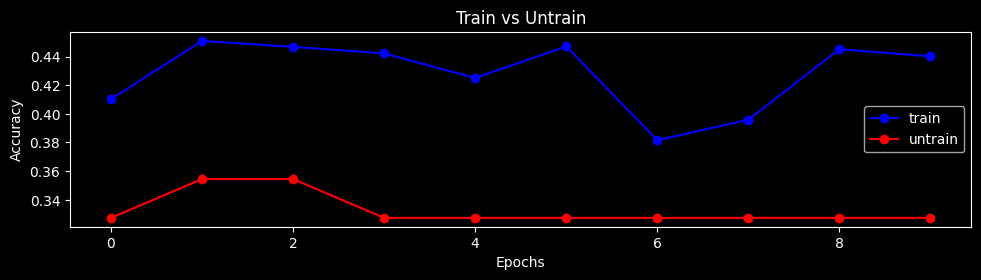

In [6]:
from tqdm.notebook import tqdm


def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    for data in dataloader:
        inputs_1, labels = data
        inputs_1, labels = inputs_1.to(device), labels.to(device).long()

        preds = model(inputs_1)
        preds = torch.argmax(preds, dim=-1)
        cnt += labels.shape[0]
        acc += (labels == preds).sum().item()

    return acc / cnt


def live_plot(
    train_accs,
    untrain_accs,
    title="Real-time Accuracy",
    label1="train",
    label2="untrain",
):
    # 플롯 크기 설정
    plt.figure(figsize=(10, 5))

    plt.subplot(2, 1, 1)
    x = np.arange(len(train_accs))
    plt.plot(x, train_accs, label="train", color="blue", marker="o")
    plt.plot(x, untrain_accs, label="untrain", color="red", marker="o")
    plt.title("Train vs Untrain")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # 플롯 간격 조정 및 출력
    plt.tight_layout()
    plt.show()


train_accs = []
untrain_accs = []

for epoch in range(n_epochs):
    with tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{n_epochs}",
        unit="batch",
        total=len(train_loader),
    ) as pbar:
        trained_model.train()
        untrained_model.train()
        for data in train_loader:
            trained_model.zero_grad()
            untrained_model.zero_grad()
            inputs_1, labels = data
            inputs_1, labels = inputs_1.to(device), labels.to(device).long()

            t_preds = trained_model(inputs_1)
            t_loss = loss_fn(t_preds, labels)
            t_loss.backward()
            t_optimizer.step()

            ut_preds = untrained_model(inputs_1)
            ut_loss = loss_fn(ut_preds, labels)
            ut_loss.backward()
            ut_optimizer.step()

        with torch.no_grad():
            trained_model.eval()
            untrained_model.eval()
            train_acc = accuracy(trained_model, test_loader)
            untrain_acc = accuracy(untrained_model, test_loader)
            train_accs.append(train_acc)
            untrain_accs.append(untrain_acc)
            print(
                f"=========> Train acc: {train_acc:.3f} | Test acc: {untrain_acc:.3f}"
            )
live_plot(train_accs, untrain_accs)

## [LOG] 에폭시를 10 에서 30으로 늘려보기
- 사전 학습 모델은 조금 증가한 듯 보이나 비학습 모델의 정확도가 뭔가 이상해보임.

=========> Train acc: 0.424 | untrain acc: 0.354
=========> Train acc: 0.434 | untrain acc: 0.327
=========> Train acc: 0.417 | untrain acc: 0.327
=========> Train acc: 0.443 | untrain acc: 0.327
=========> Train acc: 0.464 | untrain acc: 0.327
=========> Train acc: 0.450 | untrain acc: 0.327
=========> Train acc: 0.457 | untrain acc: 0.327
=========> Train acc: 0.445 | untrain acc: 0.327
=========> Train acc: 0.453 | untrain acc: 0.327
=========> Train acc: 0.455 | untrain acc: 0.354
=========> Train acc: 0.449 | untrain acc: 0.327
=========> Train acc: 0.431 | untrain acc: 0.327
=========> Train acc: 0.461 | untrain acc: 0.327
=========> Train acc: 0.417 | untrain acc: 0.327
=========> Train acc: 0.438 | untrain acc: 0.327
=========> Train acc: 0.458 | untrain acc: 0.327
=========> Train acc: 0.420 | untrain acc: 0.327
=========> Train acc: 0.466 | untrain acc: 0.327
=========> Train acc: 0.464 | untrain acc: 0.327
=========> Train acc: 0.440 | untrain acc: 0.327
=========> Train acc

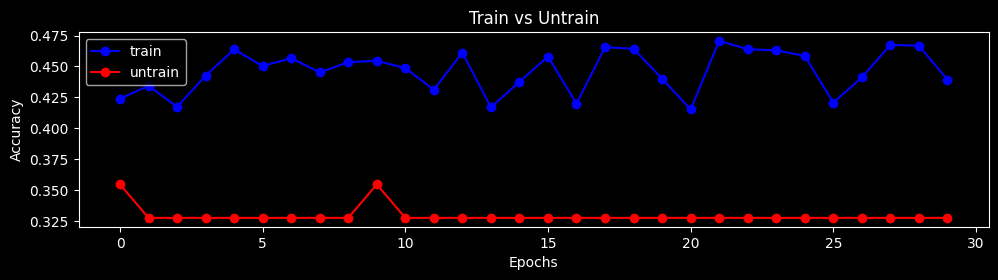

In [5]:
def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    for data in dataloader:
        inputs_1, labels = data
        inputs_1, labels = inputs_1.to(device), labels.to(device).long()

        preds = model(inputs_1)
        preds = torch.argmax(preds, dim=-1)
        cnt += labels.shape[0]
        acc += (labels == preds).sum().item()

    return acc / cnt


def live_plot(
    train_accs,
    untrain_accs,
    title="Real-time Accuracy",
    label1="train",
    label2="untrain",
):
    # 플롯 크기 설정
    plt.figure(figsize=(10, 5))

    plt.subplot(2, 1, 1)
    x = np.arange(len(train_accs))
    plt.plot(x, train_accs, label="train", color="blue", marker="o")
    plt.plot(x, untrain_accs, label="untrain", color="red", marker="o")
    plt.title("Train vs Untrain")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # 플롯 간격 조정 및 출력
    plt.tight_layout()
    plt.show()

trained_model_2 = MNLIClassifier()
untrained_model_2 = UnpretrainedMNLIClassifier()
t_optimizer_2 = Adam(trained_model_2.parameters(), lr=lr)
ut_optimizer_2 = Adam(untrained_model_2.parameters(), lr=lr)
trained_model_2 = trained_model_2.to(device)
untrained_model_2 = untrained_model_2.to(device)
n_epochs=30

for param in trained_model_2.encoder.parameters():
    param.requires_grad = False


train_accs_e30 = []
untrain_accs_e30 = []

for epoch in range(n_epochs):
    trained_model_2.train()
    untrained_model_2.train()
    for data in train_loader:
        trained_model_2.zero_grad()
        untrained_model_2.zero_grad()
        inputs_1, labels = data
        inputs_1, labels = inputs_1.to(device), labels.to(device).long()

        t_preds = trained_model_2(inputs_1)
        t_loss = loss_fn(t_preds, labels)
        t_loss.backward()
        t_optimizer_2.step()

        ut_preds = untrained_model_2(inputs_1)
        ut_loss = loss_fn(ut_preds, labels)
        ut_loss.backward()
        ut_optimizer_2.step()

    with torch.no_grad():
        trained_model_2.eval()
        untrained_model_2.eval()
        train_acc = accuracy(trained_model_2, test_loader)
        untrain_acc = accuracy(untrained_model_2, test_loader)
        train_accs_e30.append(train_acc)
        untrain_accs_e30.append(untrain_acc)
        print(f"=========> Train acc: {train_acc:.3f} | untrain acc: {untrain_acc:.3f}")
live_plot(train_accs_e30, untrain_accs_e30)

## [LOG] 파라미터 고정 해제해보기
- 사전 학습 모델의 파라미터 고정을 해제하고, 미세한 조정을 위해 lr 값을 더 작게 수정

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


=========> Train acc: 0.635 | Untrain acc: 0.318
=========> Train acc: 0.679 | Untrain acc: 0.338
=========> Train acc: 0.692 | Untrain acc: 0.354
=========> Train acc: 0.697 | Untrain acc: 0.327
=========> Train acc: 0.707 | Untrain acc: 0.327
=========> Train acc: 0.723 | Untrain acc: 0.354
=========> Train acc: 0.716 | Untrain acc: 0.328
=========> Train acc: 0.719 | Untrain acc: 0.337
=========> Train acc: 0.719 | Untrain acc: 0.354
=========> Train acc: 0.716 | Untrain acc: 0.431


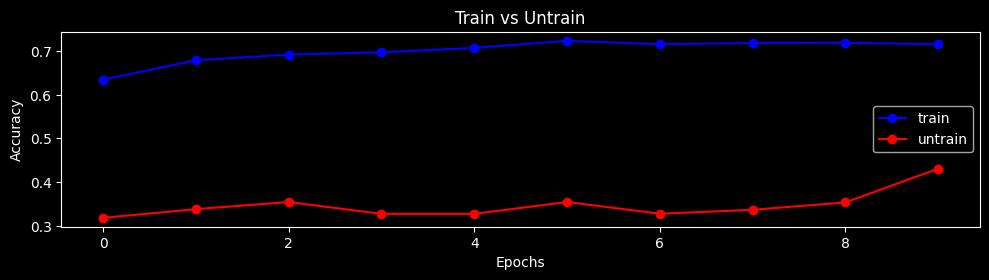

In [1]:
import pandas as pd
from datasets import Dataset
from torch import nn
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertConfig, BertModel
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset

train_data_path = (
    "/Users/yunhyeokchoi/Study/AI 99+/archive/train.csv"
)
test_data_path = "/Users/yunhyeokchoi/Study/AI 99+/archive/validation_matched.csv"

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

train_data = Dataset.from_pandas(train_data)
test_data = Dataset.from_pandas(test_data)

tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")

unnecessary_col = [
    "promptID",
    "pairID",
    "premise_binary_parse",
    "premise_parse",
    "hypothesis_binary_parse",
    "hypothesis_parse",
    "genre",
]

# 필요한 열만 유지
train_data = train_data.remove_columns(unnecessary_col)
test_data = test_data.remove_columns(unnecessary_col)

def collate_fn(batch):
    text_1, text_2, labels = [], [], []
    for row in batch:
        if row["premise"] and row["hypothesis"]:  # None 또는 빈 값 확인
            text_1.append(row["premise"])
            text_2.append(row["hypothesis"])
            labels.append(row["label"])

    if len(text_1) == 0 or len(text_2) == 0:
        raise ValueError("Batch contains no valid data.")

    encodings = tokenizer(
        text_1, text_pair=text_2, padding=True, truncation=True, return_tensors="pt"
    )
    return encodings["input_ids"], torch.tensor(labels)

train_data = train_data.select(range(10000))  # 학습 시간을 고려해 데이터 줄이기 (2만 -> 1만으로 줄이기)
train_data = train_data.with_format("torch")
train_loader = DataLoader(
    train_data, batch_size=32, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_data.with_format("torch"), batch_size=64, shuffle=False, collate_fn=collate_fn
)

class MNLIClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # TinylBERT 모델 로드
        self.encoder = AutoModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
        self.classifier = nn.Linear(312, 3)

    def forward(self, x1):
        # TinylBERT 출력
        output = self.encoder(x1)
        CLS_token = output["last_hidden_state"][:, 0]
        x = self.classifier(CLS_token)
        return x

class UnpretrainedMNLIClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # TinylBERT 설정 생성
        tinybert_config = BertConfig(
            hidden_size=312,  # Hidden size
            num_hidden_layers=4,  # Transformer layers
            num_attention_heads=12,  # Attention heads
            intermediate_size=1200,  # Feedforward layer size
            hidden_dropout_prob=0.1,  # Dropout probability
        )

        # 사전 학습되지 않은 TinylBERT 모델 로드
        self.encoder = BertModel(tinybert_config)
        self.classifier = nn.Linear(312, 3)

    def forward(self, x1):
        # TinylBERT 출력
        output = self.encoder(x1)
        CLS_token = output["last_hidden_state"][:, 0]
        x = self.classifier(CLS_token)
        return x

device = torch.device("mps") if torch.backends.mps.is_built() else torch.device("cpu")

def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    for data in dataloader:
        inputs_1, labels = data
        inputs_1, labels = inputs_1.to(device), labels.to(device).long()

        preds = model(inputs_1)
        preds = torch.argmax(preds, dim=-1)
        cnt += labels.shape[0]
        acc += (labels == preds).sum().item()

    return acc / cnt

def live_plot(
    train_accs,
    untrain_accs,
    title="Real-time Accuracy",
    label1="train",
    label2="untrain",
):
    # 플롯 크기 설정
    plt.figure(figsize=(10, 5))

    plt.subplot(2, 1, 1)
    x = np.arange(len(train_accs))
    plt.plot(x, train_accs, label="train", color="blue", marker="o")
    plt.plot(x, untrain_accs, label="untrain", color="red", marker="o")
    plt.title("Train vs Untrain")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # 플롯 간격 조정 및 출력
    plt.tight_layout()
    plt.show()

trained_model = MNLIClassifier()
untrained_model = UnpretrainedMNLIClassifier()

lr = 0.00001 # 미세한 조정을 위해 학습률 수정
trained_model = trained_model.to(device)
untrained_model = untrained_model.to(device)

loss_fn = nn.CrossEntropyLoss()
t_optimizer = Adam(trained_model.parameters(), lr=lr)
ut_optimizer = Adam(untrained_model.parameters(), lr=lr)
n_epochs = 10

for param in trained_model.encoder.parameters(): # 파라미터 고정 해제
    param.requires_grad = True

for param in untrained_model.encoder.parameters(): # 비학습 모델의 파라미터 고정 해제
    param.requires_grad = True


train_accs = []
untrain_accs = []

for epoch in range(n_epochs):
    trained_model.train()
    untrained_model.train()
    for data in train_loader:
        trained_model.zero_grad()
        untrained_model.zero_grad()
        inputs_1, labels = data
        inputs_1, labels = inputs_1.to(device), labels.to(device).long()

        t_preds = trained_model(inputs_1)
        t_loss = loss_fn(t_preds, labels)
        t_loss.backward()
        t_optimizer.step()

        ut_preds = untrained_model(inputs_1)
        ut_loss = loss_fn(ut_preds, labels)
        ut_loss.backward()
        ut_optimizer.step()

    with torch.no_grad():
        trained_model.eval()
        untrained_model.eval()
        train_acc = accuracy(trained_model, test_loader)
        untrain_acc = accuracy(untrained_model, test_loader)
        train_accs.append(train_acc)
        untrain_accs.append(untrain_acc)
        print(f"=========> Train acc: {train_acc:.3f} | Untrain acc: {untrain_acc:.3f}")
live_plot(train_accs, untrain_accs)